Steane code logical operation with software decoding
============================================

In this workbook logical operations for the Steane code are compared with the equivalent operations for a single qubit.  The workbook is set up without transpilation and iterates through a number of scaling error factors.

1. Set up logical zero for Steane code based  on the parity matrix in the book by Nielsen MA, Chuang IL. Quantum Computation and Quantum Information, 10th Anniversary Edition. Cambridge University Press; 2016. p. 474 

2. Set up physical Hadamard, CX and X to produce a physical Bell pair.

2. Set up logical Hadamard, CX and X to produce a logical Bell pair.

3. Set up the ancilla for the logical qubits

4. Attempt to correct the logical data qubits using decoding software.

5. Assess how many data qubits would give a valid logical Bell state and compare to the physical qubits.

6. Repeat for different noise scaling factors.

Import the necessary function modules, including the SteaneCodeLogicalQubit class and helper functions.

In [1]:
from qiskit import(
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer
    )

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.compiler import transpile

from circuits import SteaneCodeLogicalQubit

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from helper_functions import (
    count_valid_output_strings,
    find_individual_ancilla_values,
    find_ancilla_values,
    find_parity,
    get_noise,
    summarise_logical_counts,
    mean_of_list,
    calculate_standard_error,
    flip_code_words, 
    correct_qubit,
    convert_codewords,
    look_up_data,
    print_time,
    get_parity_check_matrix,
    get_codewords
    )

Define constants so that the process flow can be controlled from one place:

In [2]:
DATA_QUBITS = 7
ANCILLA_QUBITS = 3
SPACE = ' '
FACTOR_LIST = [1, 0.1, 0.01, 0.001, 0.0001]
TITLE1 = 'Bell pair fidelity in logical and physical qubits '

#use standard gate set without transpilation
SINGLE_GATE_SET  = ['id', 'x', 'y', 'z', 'h']
TWO_GATE_SET = ['cx', 'cz']

NOISE = True                            #Test with noise
SHOTS = 100000                          #Number of shots to run    
MEASURE_NOISE = 0.0046                  #Measurement noise
SINGLE_GATE_DEPOLARISING = 0.000366     #Single gate noise   
TWO_GATE_DEPOLARISING = 0.022           #Two gate noise 
ITERATIONS = 25

SIMULATOR = Aer.get_backend('qasm_simulator')

Specify the parity check matrix, since this defines the Steane code.  It is validated before the logical qubit is initiated to check that it is orthogonal to the valid codewords.

In [3]:
parity_check_matrix = get_parity_check_matrix()
print(parity_check_matrix)

['0001111', '0110011', '1010101']


The allowed codewords for the logical zero from Nielsen and Chuang is stored in a list.  Note, the order of qubits in the list is reversed compared to the normal output of Qiskit.

In [4]:
codewords = get_codewords()
print(codewords)

['0000000', '1010101', '0110011', '1100110', '0001111', '1011010', '0111100', '1101001']


In [5]:
#carryout a bit flip of the list of codewords to find the codewords for the logical one.
flipped_codewords = flip_code_words(codewords)

In [6]:
#The allowed codewords for a single qubit Bell pair
bell_valid_codewords = ['01','10']

Physical qubits circuit for Bell pair
-------------------------------------------------

Function module to set up a Bell pair with two physical qubits.

In [7]:
def execute_physical_qubits(measure_noise, single_gate_depolarising, two_gate_depolarising):
    print()
    print('Physical qubits Bell pair')
    error_rate_list = []
    for iteration in range(ITERATIONS):
        #print(f'For iteration {iteration}')
        qr = QuantumRegister(2,'code_qubit')     # Two code QBits
        cr = ClassicalRegister(2,'syndrome_bit') # Two registers
        qc = QuantumCircuit(qr, cr)
        qc.h(qr[0])
        qc.x(qr[1])
        qc.cx(qr[0],qr[1])
        qc.measure(qr, cr)
        #initialise circuit
        if NOISE:
            noise_model = get_noise(measure_noise, single_gate_depolarising, 
                                    two_gate_depolarising, SINGLE_GATE_SET , TWO_GATE_SET
                                   )
        if NOISE:
            result = execute(qc, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
        else:
            result = execute(qc, SIMULATOR, shots = SHOTS).result()
        counts = result.get_counts(qc)
        count_valid, count_invalid, _ = count_valid_output_strings(counts, bell_valid_codewords, 0)
        #print(f'The results are {counts}')
        #print(f'Valid codewords {bell_valid_codewords}')      
        error_rate = count_invalid / SHOTS
        #print(f'The error rate is {error_rate:.4f}')
        #print()
        error_rate_list.append(error_rate)
    mean_error_physical = mean_of_list(error_rate_list)
    standard_deviation_physical, standard_error_physical = calculate_standard_error(error_rate_list)
    print(f'The mean error rate is {mean_error_physical:.8f} and the standard error is {standard_error_physical:.8f}')
    return(mean_error_physical, standard_error_physical)

Logical Bell pair
-----------------------

Function module to set up the Bell pair with two logical qubits.

In [8]:
def set_up_circuit():
    qubit = SteaneCodeLogicalQubit(2, parity_check_matrix, codewords)
    for index in range(2):
        qubit.set_up_logical_zero(index)
    qubit.barrier()
    qubit.logical_gate_H(0)
    qubit.logical_gate_X(1)    
    qubit.logical_gate_CX(0, 1)
    qubit.barrier()
    for index in range(2):
        qubit.set_up_ancilla(index)
        qubit.barrier()
        qubit.logical_measure_data(index)
        qubit.logical_measure_ancilla(index)
    return(qubit)

Function module to execute the logical Bell pair.  For items in the counts dictionary the data qubits are corrected based on the ancilla measurements.  Each data qubit measurements is then decoded to:
 - 0 if the bit string is in the set of logical zero bitstring
 - 1 if the bit string is in the set of logical one bitstring
 - 2 if the bitstring is outside the codespace of valid bitstrings

A check is made to find out if the string of two bits after decoding is in the set of valid bell pairs {'01' and '10'}
Finally the results of the calculation are summarised and returned.

In [9]:
def execute_logical_qubits(measure_noise, single_gate_depolarising, two_gate_depolarising):
    print()
    print('Logical qubits Bell pair')
    corrected_key =''
    invalid_list = []
    valid_list = []
    for iteration in range(ITERATIONS):
        corrected_counts = {}
        new_counts = {}
        qubit = set_up_circuit()
        if NOISE:
                noise_model = get_noise(measure_noise, single_gate_depolarising, 
                                        two_gate_depolarising, SINGLE_GATE_SET , TWO_GATE_SET
                                       )
                result = execute(qubit, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
        else:
                result = execute(qubit, SIMULATOR, shots = SHOTS).result()
        counts = result.get_counts(qubit)
        corrected_data = []
        for key, values in counts.items():
            #print('key, values', key, values)
            # Z ancilla2
            key0 = key.split()[0]
            # X ancilla2
            key1 = key.split()[1]
            #data qubits2
            key2 = key.split()[2]
            # Z ancilla1
            key3 = key.split()[3]
            # X ancilla1
            key4 = key.split()[4]
            #data qubits1
            key5 = key.split()[5]           
            corrected_data0 = correct_qubit(key2, key0, DATA_QUBITS)
            corrected_data1 = correct_qubit(key5, key3, DATA_QUBITS)
            corrected_key = key0 + SPACE + key1 + SPACE + corrected_data0 + SPACE
            corrected_key = corrected_key + key3 + SPACE + key4 + SPACE + corrected_data1
            value_found = corrected_counts.get(corrected_key)
            if value_found:
                corrected_counts[corrected_key] = value_found + values
            else:
                corrected_counts.update({corrected_key: values})  
        new_counts = summarise_logical_counts(corrected_counts, codewords, flipped_codewords, 2, 5)  
        count_valid, count_invalid, _ = count_valid_output_strings(new_counts, bell_valid_codewords, 0)
        invalid_list.append(count_invalid)
        valid_list.append(count_valid)
    mean_invalid = mean_of_list(invalid_list)
    total_valid = sum(valid_list)
    total_invalid = sum(invalid_list)
    total_all = total_valid + total_invalid
    print(f'There were {total_valid} valid shots and {total_invalid} invalid shots giving {total_all} in total')
    mean_error_logical = mean_invalid / SHOTS
    standard_deviation, standard_error = calculate_standard_error(invalid_list)
    standard_error_logical = standard_error / SHOTS
    print(f'On average there are {mean_invalid:.1f} invalid codewords with a standard error of {standard_error:.1f}')
    print(f'The mean error rate for a single qubit is {mean_error_logical :.8f} and the standard error is {standard_error_logical:.8f}')
    return(mean_error_logical, standard_error_logical)

Function for plotting graph

In [10]:
def plot_graph(title, factor_list, physical_list, logical_list, physical_error_list, logical_error_list):
    plt.plot(factor_list, physical_list, '.',color = '#ff8333',linestyle = '', label = 'Physical Qubits')
    plt.plot(factor_list, logical_list, '.',color = '#8333ff', linestyle = '',label = 'Logical Qubits')
    plt.errorbar(factor_list, physical_list, yerr = physical_error_list, color = '#ff8333' )
    plt.errorbar(factor_list, logical_list, yerr = logical_error_list, color = '#8333ff' )
    plt.xlabel('Error scaling factor')
    plt.ylabel('Error rate')
    plt.title(title, fontsize = '8')
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(fontsize = '8')
    fname = '/.graphs/' + title + '.png'
    plt.savefig(title)

Iterate through different noise scaling factor for physical and logical Bell pairs and append results to lists used for graphs.  The different noise scenarios are considered in turn because the simulations might take a long time to run.

Running with normal noise

Processing error scaling factor 1
Current Time = 15:11:48

Physical qubits Bell pair
The mean error rate is 0.03064720 and the standard error is 0.00010487

Logical qubits Bell pair
There were 1125601 valid shots and 1374399 invalid shots giving 2500000 in total
On average there are 54976.0 invalid codewords with a standard error of 38.0
The mean error rate for a single qubit is 0.54975960 and the standard error is 0.00037976

Processing error scaling factor 0.1
Current Time = 15:25:29

Physical qubits Bell pair
The mean error rate is 0.00312720 and the standard error is 0.00003386

Logical qubits Bell pair
There were 2323070 valid shots and 176930 invalid shots giving 2500000 in total
On average there are 7077.2 invalid codewords with a standard error of 21.6
The mean error rate for a single qubit is 0.07077200 and the standard error is 0.00021555

Processing error scaling factor 0.01
Current Time = 15:38:51

Physical qubits Bell pair
The mean error rate is 

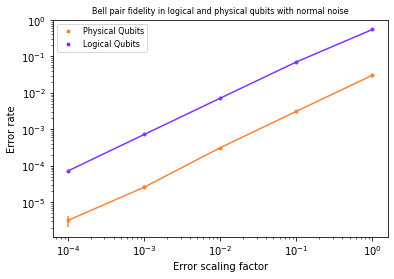

In [11]:
physical_list = []
logical_list = []
physical_error_list = []
logical_error_list = []
title2 = 'with normal noise'
print('Running with normal noise')
for factor in FACTOR_LIST:
    print()
    print(f'Processing error scaling factor {factor}')
    print_time()
    measure_noise = MEASURE_NOISE * factor
    single_gate_depolarising = SINGLE_GATE_DEPOLARISING * factor
    two_gate_depolarising = TWO_GATE_DEPOLARISING * factor
    
    mean_error, standard_error = execute_physical_qubits(measure_noise, single_gate_depolarising, two_gate_depolarising)
    physical_list.append(mean_error)
    physical_error_list.append(standard_error)
    
    mean_error, standard_error = execute_logical_qubits(measure_noise, single_gate_depolarising, two_gate_depolarising)
    logical_list.append(mean_error)
    logical_error_list.append(standard_error)
title = TITLE1 + title2
plot_graph(title, FACTOR_LIST, physical_list, logical_list, physical_error_list, logical_error_list)

Running without measure noise
Processing error scaling factor 1
Current Time = 16:19:40

Physical qubits Bell pair
The mean error rate is 0.02210520 and the standard error is 0.00008188

Logical qubits Bell pair
There were 1228729 valid shots and 1271271 invalid shots giving 2500000 in total
On average there are 50850.8 invalid codewords with a standard error of 30.0
The mean error rate for a single qubit is 0.50850840 and the standard error is 0.00029986
Processing error scaling factor 0.1
Current Time = 16:33:09

Physical qubits Bell pair
The mean error rate is 0.00218040 and the standard error is 0.00002553

Logical qubits Bell pair
There were 2344002 valid shots and 155998 invalid shots giving 2500000 in total
On average there are 6239.9 invalid codewords with a standard error of 15.8
The mean error rate for a single qubit is 0.06239920 and the standard error is 0.00015787
Processing error scaling factor 0.01
Current Time = 16:46:40

Physical qubits Bell pair
The mean error rate is

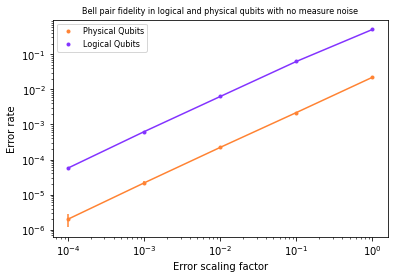

In [12]:
physical_list = []
logical_list = []
physical_error_list = []
logical_error_list = []
title2 = 'with no measure noise'
print('Running without measure noise')
for factor in FACTOR_LIST:
    print(f'Processing error scaling factor {factor}')
    print_time()
    measure_noise = 0
    single_gate_depolarising = SINGLE_GATE_DEPOLARISING * factor
    two_gate_depolarising = TWO_GATE_DEPOLARISING * factor
    
    mean_error, standard_error = execute_physical_qubits(measure_noise, single_gate_depolarising, two_gate_depolarising)
    physical_list.append(mean_error)
    physical_error_list.append(standard_error)
    
    mean_error, standard_error = execute_logical_qubits(measure_noise, single_gate_depolarising, two_gate_depolarising)
    logical_list.append(mean_error)
    logical_error_list.append(standard_error)
title = TITLE1 + title2
plot_graph(title, FACTOR_LIST, physical_list, logical_list, physical_error_list, logical_error_list)

Running with single and two gate noises same
Processing error scaling factor 1
Current Time = 17:26:32

Physical qubits Bell pair
The mean error rate is 0.02200600 and the standard error is 0.00010175

Logical qubits Bell pair
There were 1228809 valid shots and 1271191 invalid shots giving 2500000 in total
On average there are 50847.6 invalid codewords with a standard error of 37.3
The mean error rate for a single qubit is 0.50847640 and the standard error is 0.00037291
Processing error scaling factor 0.1
Current Time = 17:40:08

Physical qubits Bell pair
The mean error rate is 0.00217200 and the standard error is 0.00003285

Logical qubits Bell pair
There were 2343605 valid shots and 156395 invalid shots giving 2500000 in total
On average there are 6255.8 invalid codewords with a standard error of 18.0
The mean error rate for a single qubit is 0.06255800 and the standard error is 0.00017988
Processing error scaling factor 0.01
Current Time = 17:54:02

Physical qubits Bell pair
The mea

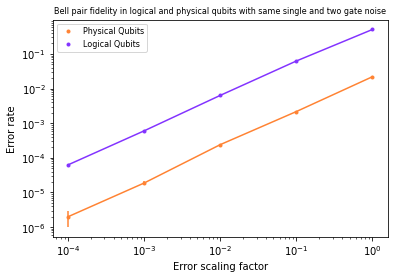

In [13]:
physical_list = []
logical_list = []
physical_error_list = []
logical_error_list = []
title2 = 'with same single and two gate noise'
print('Running with single and two gate noises same')
for factor in FACTOR_LIST:
    print(f'Processing error scaling factor {factor}')
    print_time()
    measure_noise = 0
    single_gate_depolarising = SINGLE_GATE_DEPOLARISING * factor
    two_gate_depolarising = TWO_GATE_DEPOLARISING * factor
    
    mean_error, standard_error = execute_physical_qubits(measure_noise, single_gate_depolarising, two_gate_depolarising)
    physical_list.append(mean_error)
    physical_error_list.append(standard_error)
    
    mean_error, standard_error = execute_logical_qubits(measure_noise, single_gate_depolarising, two_gate_depolarising)
    logical_list.append(mean_error)
    logical_error_list.append(standard_error)
title = TITLE1 + title2
plot_graph(title, FACTOR_LIST, physical_list, logical_list, physical_error_list, logical_error_list)